<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Image display demo for the IAU General Assembly LSST RSP workshop, August 2024</b> <br>
Rubin Science Platform deployment: data.lsst.cloud <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Last verified to run: Tue Aug 13 2024 <br>
Contact author: Christina Williams <br>




<br>


Learn more about the Data Preview 0 data set (e.g., image types, catalog tables)
and the LSST Science Pipelines and Rubin Science Platform functionality using the
documentation and resources available at <a href="https://dp0.lsst.io/">dp0.lsst.io</a>.

<br>


**Description:** Learn to display and manipulate images using the LSST Science Pipelines.

**Skills:** Display and manipulate images, explore image mask planes, and create cutouts.

**LSST Data Products:** Butler calexp and deepCoadd images, coadd objectTable

**Packages:** lsst.afw.display, lsst.daf.butler, lsst.geom, lsst.afw.image

**Credit:** This tutorial is based on the [`AFW_Display_Demo.ipynb`](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Visualization/AFW_Display_Demo.ipynb) notebook originally written by Brant Robertson and maintained by the LSST Stack Club. ADD THE OTHERS HERE

More examples of the use of `lsst.afw.display` can be found in the [LSST Science Pipelines documentation](https://pipelines.lsst.io/getting-started/display.html).

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>.
Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial is designed to introduce users to accessing imaging data products produced by the LSST pipelines, their format, and basic image display and manipulation. 

It also introduces LSST pipeline packages that are useful for basic access:  the `lsst.afw.display` library that enables the visual inspection of image data. The [`lsst.afw` library](https://github.com/lsst/afw) provides an "Astronomical Framework" (afw) while the `lsst.daf.*` libraries (see, e.g., [daf_base](https://github.com/lsst/daf_base)) provide a "Data Access Framework" (daf). Both libraries are used in this tutorial, with the `lsst.daf.butler` library used to access image data and the `lsst.afw.display` library used to display the image data.

### 1.1. Package imports

Below, the `matplotlib.pyplot` sublibrary is imported for plotting, and the [`astropy.wcs`](https://docs.astropy.org/en/stable/wcs/index.html) package is imported for dealing with World Coordinate Systems (WCS).
The [`matplotlib`](https://matplotlib.org/) and [`astropy`](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis.
The `gc` (garbage collector) package is imported to help clear the memory of large plots.

The `lsst.afw.display` and `lsst.afw.image` modules are loaded to gain access to the image visualization routines we'd like to use, and the `lsst.daf.butler` and `lsst.rsp.get_tap_service` modules are used to access data products.
The `lsst.geom` package is used for dealing with sky coordinates.

In [1]:
# general-use python packages
import matplotlib.pyplot as plt
import gc
import sys

# Astropy packages
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.wcs import WCS

# LSST Pipeline packages for data access:
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service

# LSST Pipeline package for dealing with sky coordinates
import lsst.geom as geom

# LSST Pipieline packages for image manipulation and display
import lsst.afw.display as afwDisplay
from lsst.afw.image import Exposure, ExposureF


### 1.2. Define functions and parameters

#### 1.2.1. Functions

Matplotlib stores the data array associated with an image that is plotted. Since the LSST Charge-Coupled Device (CCD) detector images are large (~4k x 4k pixels), this can eventually lead to a memory overflow, which will cause the notebook kernel to die. To mitigate this issue, we define a function to clean up after we plot them.

In [2]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

Set the parameters of `matplotlib.pyplot` to give us a large default size for an image, and set some other parameters to make the default plot style be color-blind friendly and otherwise make plots look nice.

In [3]:
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [4]:
params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

## 2. Intro to Image Data

This tutorial focuses on two common types of images people will interact with: calexps and deepCoadds.

<b>calexp: A calibrated exposure (single image in a single filter).</b>

Calexp files are uniquely identified by visit (when observation was taken) and detector in the camera.  

<img src="figures/img_demonstration.png" width="400">
Figure 1: Example of many calexp footprints (magenta) that are combined into deepCoadds (gray)
<br><br>
<b>deepCoadd: A combination of single images into a deep stack or Coadd.</b>

The LSST Science Pipelines processes and stores deepCoadd images in tracts and patches.

tract: A portion of sky within the LSST all-sky tessellation (sky map); divided into patches.

patch: A quadrilateral sub-region of a tract, of a size that fits easily into memory on desktop computers.

<img src="figures/dp02_patch_tract.png" width="700">
Figure 2: Example tract divided into patches in DP0.2 (REF)
<br><br>
To retrieve and display an image at a desired coordinate, users have to specify their image type, and additional parameters, which make up whats called a `dataId` : tract, patch and filter are needed in the case of `deepCoadd` ; only the visit and detector are needed in the case of `calexp`.

## 2.1. Retrieve an image using the LSST Butler

The butler (<a href="https://pipelines.lsst.io/modules/lsst.daf.butler/index.html">documentation</a>) is an LSST Science Pipelines software package to fetch LSST data without having to know its location or format. This is the preferred method for image retrieval using the RSP Notebook aspect.

The DP0.2 data set contains simulated images from the LSST DESC Data Challenge 2 (DC2) that have been reprocessed by the LSST Project using a more recent version of the LSST Science Pipelines.  

### 2.1.1 Create an instance of the butler 
Specify data set of imaging contained in the RSP to use. Request simulated DP0.2 imaging by directing the Butler to the `dp02` data repository configuration, and the collection `2.2i/runs/DP0.2` specifies which processing run using the LSST pipelines to use. 

It will return an informative statement about credentials being found.

In [5]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

### 2.1.2 Identify and retrieve a deepCoadd
There is a cool-looking galaxy cluster in the DP0.2 simulated data at RA = 03h42m59.0s, Dec = -32d16m09s (in degrees, 55.745834, -32.269167).

Use the LSST `geom` package to define a `SpherePoint` (an LSST pipeline object to hold coordinates) for the cluster's coordinates (<a href="https://pipelines.lsst.io/modules/lsst.geom/index.html">lsst.geom documentation</a>).


In [6]:
my_ra = 55.745834
my_dec = -32.269167

my_spherePoint = geom.SpherePoint(my_ra*geom.degrees,
                                  my_dec*geom.degrees)
print(my_spherePoint)

(55.7458340000, -32.2691670000)


Retrieve the DP0.2 sky map from the butler. This is simply a reference of how the all sky area is divided up into patch and tracts. Use it to identify the tract and patch for the cluster's coordinates (<a href="http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/skymap.html">skymap documentation</a>).

In [7]:
skymap = butler.get('skyMap')

tract = skymap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)

my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()

print('my_tract: ', my_tract)
print('my_patch: ', my_patch)



my_tract:  4431
my_patch:  17


Use the butler to retrieve the i-band deepCoadd for the tract and patch. To do this, we define a dictionary called `dataId` with the required information (for deepCoadds, to uniquely identify the image, the user must provide 3 things: the filter (band), patch, and tract). 

In [8]:
dataId = {'band': 'i', 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=dataId)


### 2.1.3 LSST image format

The `my_deepCoadd` returned by the Butler contains the science image, and also has a number of extensions containing other data or information about the image. This includes the science image, a mask plane containing the masked pixels and why they were masked, and spatially varying PSF information.

These examples will focus on just the science and mask extensions (see the tutorial-notebooks github repo for additional demonstrations). 

The extension containing the science image and masks can be returned using the `image` and `mask` attributes. One can retrieve just an array containing the pixels values using `.array` attribute.

In [9]:
deepCoadd_image = my_deepCoadd.image
deepCoadd_pixels = my_deepCoadd.image.array
deepCoadd_mask = my_deepCoadd.mask
deepCoadd_var = my_deepCoadd.variance


## 3. Basic image visualization

### 3.1 Use AFWDisplay to visualize the image
Image data retrieved with the butler is an `Exposure` or `ExposureF` (F=float) Python object. Exposures are the native format for imaging data taken with Rubin and processed by LSST Pipelines. They are powerful representations of image data because they contain not only the image data, but also a variance image for uncertainty propagation, a bit mask image, and key-value metadata. In the next section, we will use `afwDisplay` to visualize the image and mask associated with this Exposure. More documentation on accessing and visualizing an Exposure object be found [here](https://pipelines.lsst.io/getting-started/display.html).

The image contained in the `ExposureF` object can be displayed several different ways. A simple option is to use the LSST Science Pipelines package `afwDisplay`. There is some <a href="https://pipelines.lsst.io/modules/lsst.afw.display/index.html">documentation for afwDisplay</a> available, and other DP0 tutorials LINK go into more detail about all the display options (e.g., overlaying mask data to show bad pixels).



#### 3.1.1 Interactive Display using afwDisplay

First, explore the image using an interactive display called `firefly`, which is the RSP's interface for interactive image display and manipulation. 

1. Create an alias to the `lsst.afw.display.Display` method that will allow us to display the data to the screen.  This alias will be called `firefly_display`.
2. Display the image by providing the `mtv()` method the `deepCoadd.image` member of our calibrated image retrieved by the `butler`.

In [10]:
afwDisplay.setDefaultBackend('firefly')
firefly_display = afwDisplay.Display(frame=1)
firefly_display.mtv(deepCoadd_image)


#### 3.1.2 Static Image Display using afwDisplay

It is also possible to plot statically in the notebook. To do this, set the backend of afwDisplay to matplotlib.


In [11]:
afwDisplay.setDefaultBackend('matplotlib')


The following code cell creates a matplotlib.pyplot figure; aliases `lsst.afw.display.Display` as `display`; 
sets the image stretch for the pixel shading (set by the algorithm asinh -- familiar from SDSS images -- with a range of values set by zscale); displays the image data using `mtv`; and turns on the x and y axes labels (pixel coordinates).

REDUNDANT WITH BELOW. PICK ONE.

We are now set to display the image. To do this, we:

1. Create a `matplotlib.pyplot` figure using `plt.figure()` -- this will be familiar to anyone with experience using `matplotlib`.
2. Create an alias to the `lsst.afw.display.Display` method that will allow us to display the data to the screen.  This alias will be called `display`.
3. Before showing the data on the screen, we have to decide how to apply an image stretch given the data. The algorithm we'll use is `asinh` -- familiar from SDSS images -- with a range of values set by `zscale`. To do this, we use the `scale()` function provided by `lsst.afw.display`. See the `scale()` function definition in the [`interface.py` file of the lsst.afw.display library](https://github.com/lsst/afw/blob/master/python/lsst/afw/display/interface.py).
4. Finally, we can display the image. To do this, we provide the `mtv()` method the `deepCoadd.image` member of our calibrated image retrieved by the `butler`. We can then use `plt.show()` to display our figure.
5. After we are done creating and displaying the image, we remove the underlying data from memory.

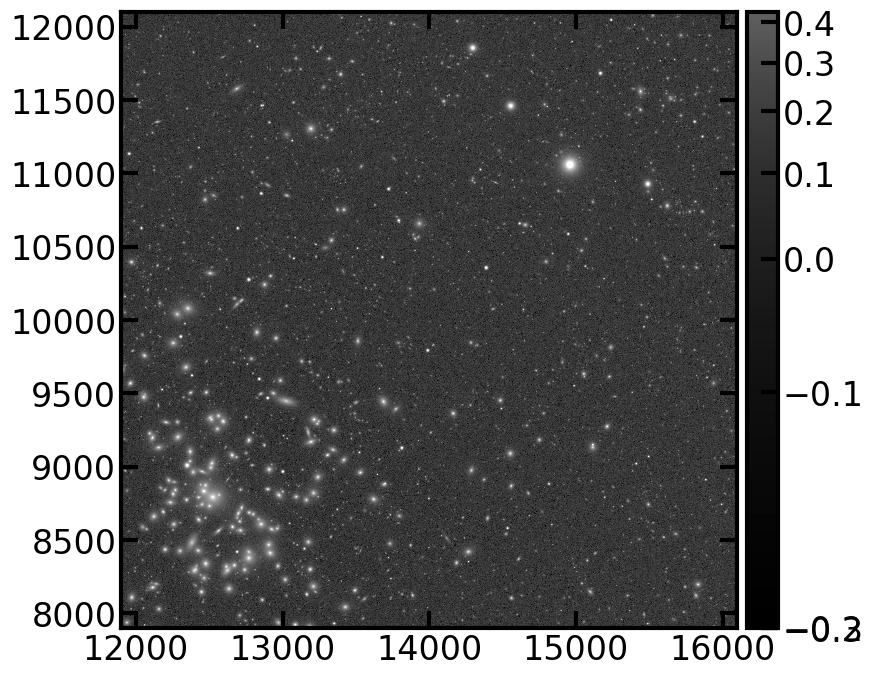

In [12]:
fig = plt.figure(figsize=(10, 8))
display = afwDisplay.Display(1)
display.scale('asinh', 'zscale')
display.mtv(my_deepCoadd.image)
plt.gca().axis('on')
plt.show()
remove_figure(fig)

#### 3.1.3 More information and help

To find more information, the next cell will print the `lsst.afw.display` methods that are available for this display type to the screen. 

In [13]:
method_list = [fun for fun in dir(display) if callable(getattr(display, fun))]
print(method_list)

['Buffering', '_Buffering', '_Display__addMissingMaskPlanes', '__class__', '__del__', '__delattr__', '__dir__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'centroids', 'close', 'delAllDisplays', 'dot', 'erase', 'flush', 'getActiveCallbackKeys', 'getDefaultBackend', 'getDefaultFrame', 'getDisplay', 'getMaskPlaneColor', 'getMaskTransparency', 'image', 'incrDefaultFrame', 'interact', 'line', 'maskColorGenerator', 'mtv', 'pan', 'scale', 'setCallback', 'setDefaultBackend', 'setDefaultFrame', 'setDefaultImageColormap', 'setDefaultMaskPlaneColor', 'setDefaultMaskTransparency', 'setImageColormap', 'setMaskPlaneColor', 'setMaskTransparency', 'show', 'zoom']


To learn more about the afwDisplay package and its tasks (e.g. `mtv`), use the help function.

In [14]:
help(display.mtv)

Help on method mtv in module lsst.afw.display.interface:

mtv(data, title='', wcs=None) method of lsst.afw.display.interface.Display instance
    Display an image on a display, with semi-transparent masks
    overlaid, if available.
    
    Notes
    -----
    Historical note: the name "mtv" comes from Jim Gunn's forth imageprocessing
    system, Mirella (named after Mirella Freni); The "m" stands for Mirella.



In [15]:
#dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

In [16]:
#calexp = butler.get('calexp', **dataId)

In [17]:
calexp = my_deepCoadd # fix later
coadd = my_deepCoadd

#fig = plt.figure()
#display = afwDisplay.Display(frame=fig)
#display.scale('asinh', 'zscale')
#display.mtv(calexp.image)
#plt.show()
#remove_figure(fig)


### 3.2 Working with World Coordinate Systems (WCS)

To see the image axes in sky coordinates instead of pixel coordinates, a simple option is to use astropy's World Coordinate System (WCS) package, along with matplotlib.pyplot's `subplot`, `imshow`, and `grid` functions. 
Recall that we imported `matplotlib.pyplot` as `plt` already, and that we imported the `astropy.wcs.WCS` constructor as simply `WCS`.
Find more information about [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) (`cmap`).

To do this, we:
1. Set the figure's projection to be the WCS of the `deepCoadd`.
2. Define the extent in pixel coordinates using the bounding box.
3. Display the deepCoadd image data array using the gray colormap (cmap)
4. Add solid white grid lines.
5. Label the axes, and show the plot.
6. Remove the underlying data from memory.

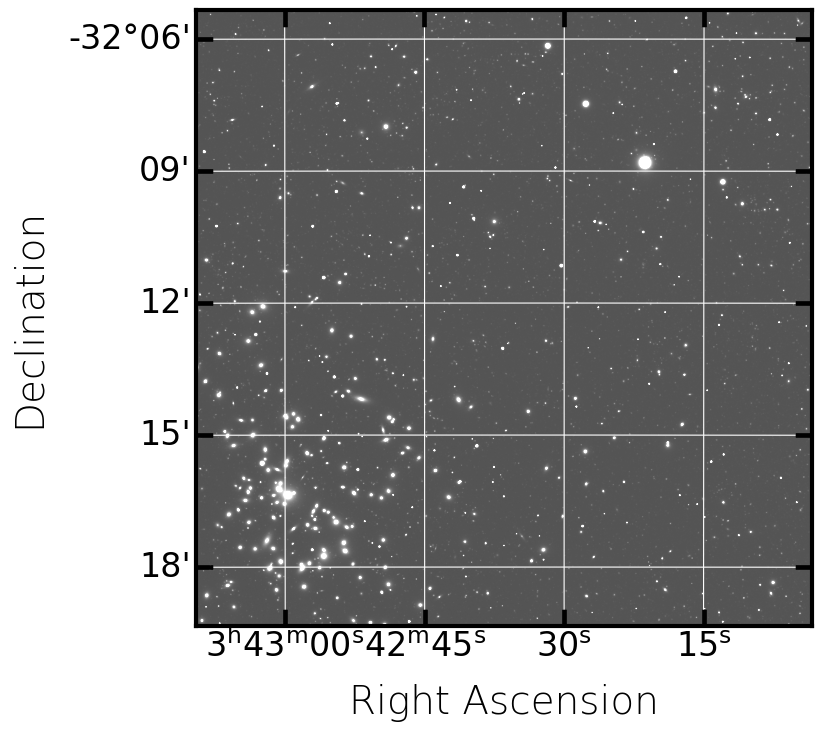

In [18]:
fig = plt.figure()

my_deepCoadd_WCS = WCS(my_deepCoadd.getWcs().getFitsMetadata())

plt.subplot(projection = my_deepCoadd_WCS)

my_deepCoadd_extent = (my_deepCoadd.getBBox().beginX, my_deepCoadd.getBBox().endX,
                       my_deepCoadd.getBBox().beginY, my_deepCoadd.getBBox().endY)

im = plt.imshow(my_deepCoadd.image.array, cmap='gray', vmin=-2.0, vmax=4,
                extent=my_deepCoadd_extent, origin='lower')

plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
remove_figure(fig)

**Congratulations!** We've plotted an image in various ways using `lsst.afw.display`!

### 3.3. Use afwDisplay to visualize the image and mask plane

The `deepCoadd` returned by the butler contains more than just the image pixel values (see this [image tutorial](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb) for more details). 
One other component is the mask associated with the image. 
A mask is composed of a set of "mask planes," 2D binary bit maps corresponding to pixels that are masked for various reasons (see [here](https://pipelines.lsst.io/v/DM-11392/getting-started/display.html#interpreting-displayed-mask-colors) for more details).

The `afwDisplay` package maps each bit in the mask plane to a specific display color. 
We can view this mapping using the code in the following cell. 
We can also use the `setMaskPlaneColor` method to change the colors that `afwDisplay` uses for each mask plane.

Print the colors associated to each plane in the mask.

In [19]:
print("Mask plane bit definitions:\n", display.getMaskPlaneColor())
print("\nMask plane methods:\n")
help(display.setMaskPlaneColor)

Mask plane bit definitions:
 {'BAD': 'red', 'CR': 'magenta', 'EDGE': 'yellow', 'INTERPOLATED': 'green', 'SATURATED': 'green', 'DETECTED': 'blue', 'DETECTED_NEGATIVE': 'cyan', 'SUSPECT': 'yellow', 'NO_DATA': 'orange', 'INTRP': 'green', 'SAT': 'green'}

Mask plane methods:

Help on method setMaskPlaneColor in module lsst.afw.display.interface:

setMaskPlaneColor(name, color=None) method of lsst.afw.display.interface.Display instance
    Request that mask plane name be displayed as color.
    
    Parameters
    ----------
    name : `str` or `dict`
        Name of mask plane or a dictionary of name -> colorName.
    color : `str`
        The name of the color to use (must be `None` if ``name`` is a
        `dict`).
    
        Colors may be specified as any X11-compliant string (e.g.
        `"orchid"`), or by one of the following constants in
        `lsst.afw.display` : `BLACK`, `WHITE`, `RED`, `BLUE`,
        `GREEN`, `CYAN`, `MAGENTA`, `YELLOW`.
    
        If the color is "ignore"

Let's plot the image and mask plane side-by-side using matplotlib subplots.

Use `plt.sca(ax[0])` to set the first axis as current, and then `plt.sca(ax[1])` to switch to the second axis.
Using `plt.tight_layout()` with multi-axis figures helps to avoid axis overlap or excessive white spaces and results in a nicer-looking plot.

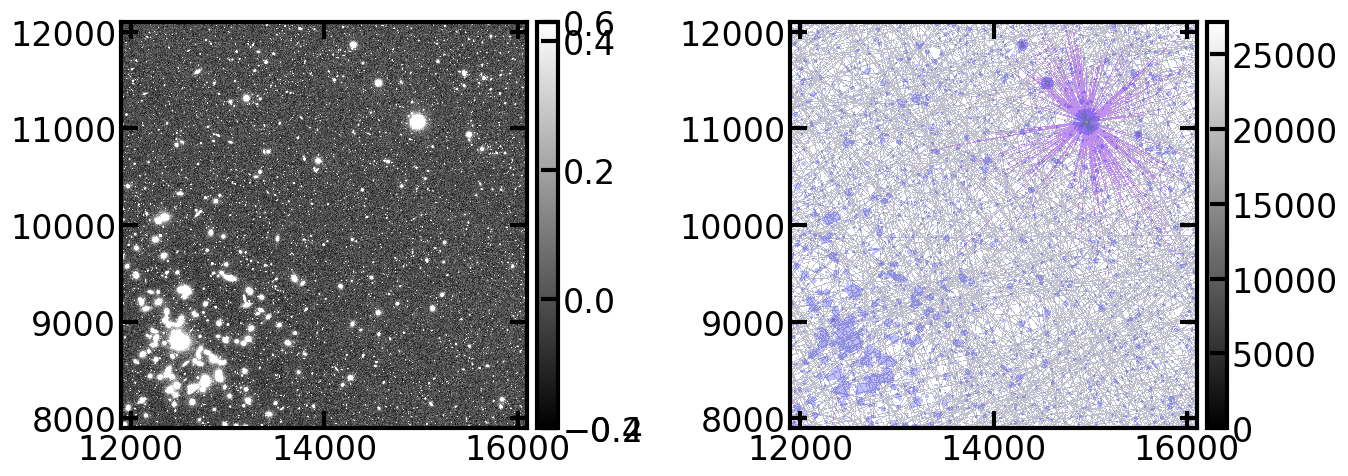

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# left panel
plt.sca(ax[0])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(my_deepCoadd.image)

# right panel
plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.mtv(my_deepCoadd.mask)
plt.tight_layout()

plt.show()

remove_figure(fig)

The `afwDisplay` package also provides a nice interface for plotting the mask on top of the image using the `my_deepCoadd.maskedImage`. 
The mask will also be plotted on top of the image if you pass the `my_deepCoadd` itself to `mtv` (as is done later in this notebook).

BAD                (bit=2**00)
CLIPPED            (bit=2**09)
CR                 (bit=2**03)
CROSSTALK          (bit=2**10)
DETECTED           (bit=2**05)
DETECTED_NEGATIVE  (bit=2**06)
EDGE               (bit=2**04)
INEXACT_PSF        (bit=2**11)
INTRP              (bit=2**02)
NOT_DEBLENDED      (bit=2**12)
NO_DATA            (bit=2**08)
REJECTED           (bit=2**13)
SAT                (bit=2**01)
SENSOR_EDGE        (bit=2**14)
SUSPECT            (bit=2**07)
UNMASKEDNAN        (bit=2**15)


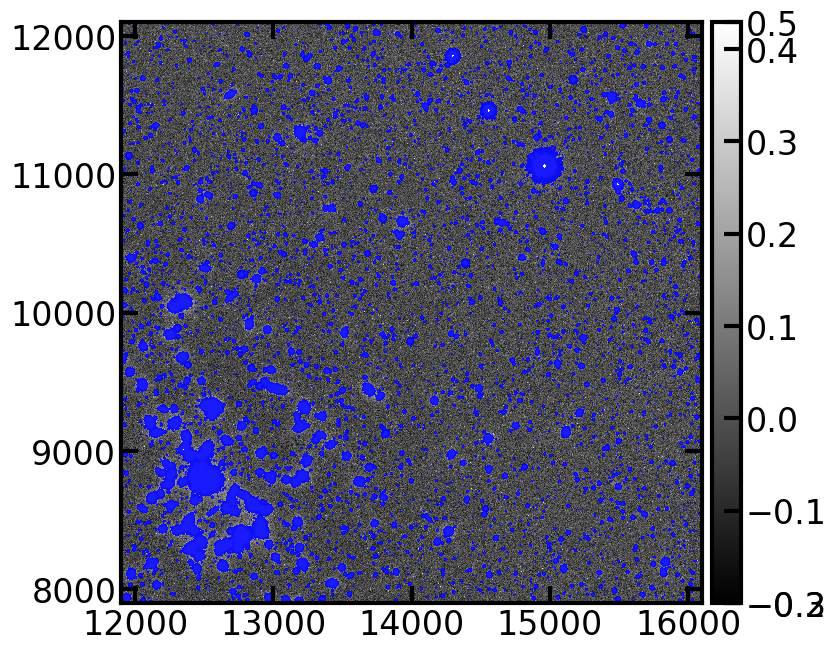

In [21]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)

for maskName, maskBit in coadd.mask.getMaskPlaneDict().items(): 
    print(f'{maskName:18s} (bit=2**{maskBit:02d})')
    display.setMaskTransparency(100,maskName)

display.setMaskTransparency(10,'DETECTED') # 'SENSOR_EDGE')
#display.setMaskPlaneColor('SENSOR_EDGE', 'yellow')


display.scale('linear', 'zscale')
display.mtv(my_deepCoadd.maskedImage)
plt.show()
remove_figure(fig)

To investigate the mask in a bit more detail, we'll follow the same steps as above to display the image, but we'll add a few modifications

1. We explicitly set the transparency of the overplotted mask
   (as a percentage: 0 = opaque, 100 = transparent)
2. We explicitly set the color of the 'DETECTED' mask plane to 'blue' (i.e., all pixels associated with detected objects).
3. We pass the full `my_deepCoadd` object to `mtv` instead of just the image plane.

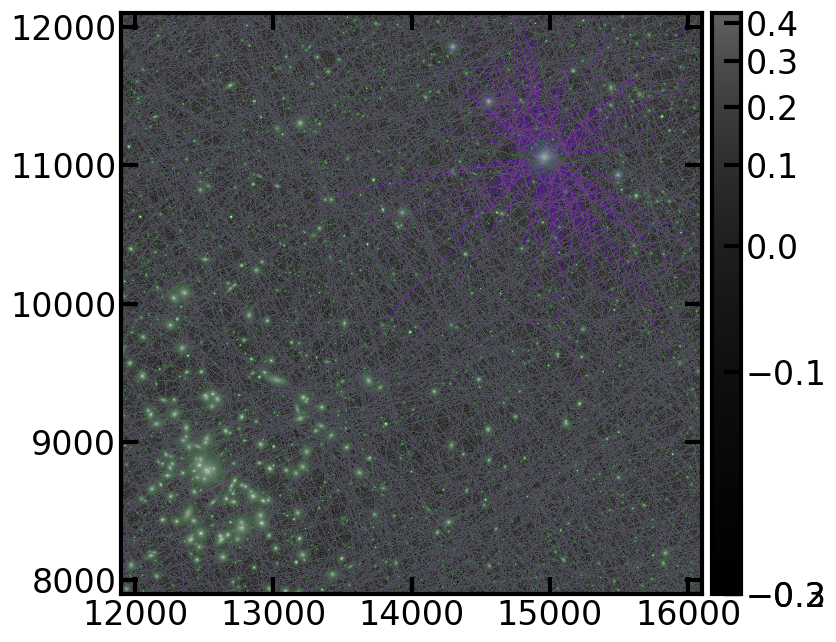

In [22]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.setMaskTransparency(80)
display.setMaskPlaneColor('DETECTED', 'green')
display.mtv(my_deepCoadd)
plt.show()
remove_figure(fig)


The image above is displaying pixel coordinates (note that the coadd patch is part of a larger coadd image called a "tract", so the pixel values do not start at 0,0), but in general it is more useful to be able to select a region based on RA, Dec coordinates. To do this, we'll use the world coordinate system (WCS) object associated with the image.

Extract the WCS solution, which provides the mapping between XY pixel values and sky coordinates, and print it.

In [23]:
wcs = my_deepCoadd.getWcs()
print(wcs)

FITS standard SkyWcs:
Sky Origin: (55.6521739130, -31.9834710744)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


The cluster seems to be centered at about (X, Y) ~ (12500, 8500).
Use the "pixelToSky" method of the WCS to get the sky coordinates.

In [24]:
radec = wcs.pixelToSky(12500, 8500)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

55.7506834813934 -32.28892993702273


TO DO: POTENTIAL PLACE TO ADD HOW TO GET CALEXPS OVERLAPPING THE CLUSTER


## 4. Accessing Images via TAP query: The ObsCore table

It is also possible to use TAP queries to access imaging information from an LSST catalog, and does not require the use of LSST Pipelines like the Butler does. A use case for this method of image access is if accessing from outside the RSP.

The LSST `ObsCore` table is essentially a view into the images
stored in the LSST's [data butler](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html) registry (for more information, see data management document, [DMTN-236](https://dmtn-236.lsst.io/)). The IVOA in the catalog's title `ivoa.ObsCore` stands for International Virtual Observatory Alliance, which sets standards for data storage (the Virtual Observatory; VO) and Rubin's data products are consistent with these VO standards.

For this part of the tutorial, import some standard VO packages that will enable data access via VO standards.

In [25]:
# PyVO packages
import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

# more LSST Pipeline packages
from lsst.resources import ResourcePath
from lsst.afw.fits import MemFileManager
from lsst.afw.image import ExposureF


Like Tutorial 2 on catalogs, we initialize the TAP service to allow queries to the `ivoa.ObsCore` table. The second line we will create store the authentication, which will be needed to access the imaging (if proprietary) from outside the RSP environment (for more information see https://rsp.lsst.io/guides/auth/creating-user-tokens.html). 

In [26]:
service = get_tap_service("tap")
auth_session = service._session

Retrieve the names of the columns and their data types, descriptions and units,
and display these properties as a pandas table. The output is a list of the image metadata that is available in the `ObsCore` table.

In [27]:
query = "SELECT column_name, datatype, description, unit " \
        "FROM tap_schema.columns " \
        "WHERE table_name = 'ivoa.ObsCore'"

results = service.search(query)
results.to_table().to_pandas()

column_name datatype  \
0         access_format     char   
1            access_url     char   
2           calib_level      int   
3   dataproduct_subtype     char   
4      dataproduct_type     char   
5                em_max   double   
6                em_min   double   
7          em_res_power   double   
8                em_xel     long   
9         facility_name     char   
10      instrument_name     char   
11            lsst_band     char   
12      lsst_ccdvisitid     long   
13        lsst_detector     long   
14          lsst_filter     char   
15           lsst_patch     long   
16           lsst_tract     long   
17           lsst_visit     long   
18                o_ucd     char   
19       obs_collection     char   
20               obs_id     char   
21    obs_publisher_did     char   
22            obs_title     char   
23              pol_xel     long   
24                s_dec   double   
25                s_fov   double   
26                 s_ra   double   
27             s_region     char   
28         s_resolution   double   
29               s_xel1     long   
30               s_xel2     long   
31            t_exptime   double   
32                t_max   double   
33                t_min   double   
34         t_resolution   double   
35                t_xel     long   
36          target_name     char   

                                          description    unit  
0                       Content format of the dataset          
1                          URL used to access dataset          
2   Calibration level of the observation: in {0, 1...          
3                          Data product specific type          
4            Data product (file content) primary type          
5                        stop in spectral coordinates       m  
6                       start in spectral coordinates       m  
7   Value of the resolving power along the spectra...          
8          Number of elements along the spectral axis          
9   The name of the facility, telescope, or space ...          
10  The name of the instrument used for the observ...          
11                   Abstract filter band designation          
12          Identifier for visit+CCD; useful in JOINs          
13  Identifier for CCD within the LSSTCam focal plane          
14  Physical filter designation from the LSSTCam f...          
15         Lower level of LSST coadd skymap hierarchy          
16         Upper level of LSST coadd skymap hierarchy          
17         Identifier for a specific LSSTCam pointing          
18                      Nature of the observable axis          
19                        Name of the data collection          
20            Internal ID given by the ObsTAP service          
21          ID for the Dataset given by the publisher          
22        Brief description of dataset in free format          
23     Number of elements along the polarization axis          
24      Central Spatial Position in ICRS; Declination     deg  
25  Estimated size of the covered region as the di...     deg  
26  Central Spatial Position in ICRS; Right ascension     deg  
27  Sky region covered by the data product (expres...          
28          Spatial resolution of data as FWHM of PSF  arcsec  
29  Number of elements along the first coordinate ...          
30  Number of elements along the second coordinate...          
31                                Total exposure time       s  
32                                   Stop time in MJD       d  
33                                  Start time in MJD       d  
34                           Temporal resolution FWHM       s  
35             Number of elements along the time axis          
36                                 Object of interest

Useful metadata includes `s_region`, which is the bounding box (spatial extent) of the image.

The following query selects all columns from the `ObsCore` table
for all images that contain the
[ICRS](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_its_realizations)
coordinate for the galaxy cluster within the `s_region`.
(In other words, where the statment that the `s_region` contains 
the ra & dec of the point is `True` or `= 1`.)

For large queries like this one, we submit "asynchronously" and wait for the job to complete before continuing.

In [28]:
query = "SELECT * FROM ivoa.ObsCore "\
        "WHERE CONTAINS(POINT('ICRS', " + str(my_ra) + \
        ", " + str(my_dec) + "), s_region) = 1"

# Define the service job using the query, then run it.
job = service.submit_job(query)
job.run()

Wait until the job is completed.

In [29]:
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


When the job phase is "COMPLETED", fetch (retrieve) the results,
and print the number of rows returned.
This is the number of images found that overlap the specified point.

In [30]:
results = job.fetch_result().to_table().to_pandas()
print(len(results))

1739



Retrive image data (headers and pixel data), for imaging. This time, we will retrieve a `calexp` image (which are single visit exposures on sky; see Section 2). 

Need to explain calib_level in simplified way (also its in the portal)


In [31]:
query = "SELECT * FROM ivoa.ObsCore "\
        "WHERE CONTAINS(POINT('ICRS', " + \
        str(my_ra) + ", " + str(my_dec) + "), s_region) = 1 "\
        "AND lsst_band = 'i' "\
        "AND calib_level = 2"
print(query)

SELECT * FROM ivoa.ObsCore WHERE CONTAINS(POINT('ICRS', 55.745834, -32.269167), s_region) = 1 AND lsst_band = 'i' AND calib_level = 2


In [32]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
results = job.fetch_result()
print(len(results))

Job phase is COMPLETED
151


Option to view results as an `astropy` table.

In [33]:
# results.to_table()

For this demonstration only one of the 128 images is needed, FIX!
so extract the first row into `results_0`.

In [34]:
results_0 = results[0]

Print selected metadata:
 * dataproduct subtype
 * CCD visit identifier (`lsst_ccdvisitid`)
 * visit identifier and detector number
 * central RA and Dec
 * band (filter)
 * exposure start time `t_min` (a modified julian date, MJD)
 * `s_region` (corner coordinates)
 * a unique `obs_id` in the TAP service

In [35]:
print(results_0['dataproduct_subtype'])
print(results_0['lsst_ccdvisitid'])
print(results_0['lsst_visit'], results_0['lsst_detector'])
print('%7.4f %8.4f' % (results_0['s_ra'], results_0['s_dec']))
print(results_0['lsst_band'])
print(results_0['t_min'])
print(results_0['s_region'])
print(results_0['obs_id'])

lsst.calexp
731790044
731790 44
55.7863 -32.3179
i
60661.1749186111
POLYGON ICRS 55.973259 -32.235656 55.686347 -32.161128 55.599060 -32.399956 55.886666 -32.474692
731790-R11_S22


#### 4.1 Access via Datalink URL

Data is accessible via an `access_url` and the format of the
data is stored in `access_format`.

In [36]:
print(results_0['access_url'])
print(results_0['access_format'])

https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/b298eb9c-be53-45c0-b624-0d9504de52bb
application/x-votable+xml;content=datalink


Above, the format indicates that the image is stored as a `votable` which is accessible via Datalink.

Obtain the table `dl_results` using Datalink and the `auth_session` that was defined earlier to authenticate data access.

In [37]:

dl_results = DatalinkResults.from_result_url(results_0['access_url'],
                                             session=auth_session)

Option to view `dl_results` as an astropy table.

In [38]:
# dl_results.to_table()

For security reasons the `dl_results` table holds a *different* `access_url` that
provides direct access to the image - define it as `image_url`
and print it to see how it is different from the `access_url` above. We need the datalink URL, which was provided once authenticated, to access the image.

In [39]:
image_url = dl_results['access_url'][0]
print(image_url)

https://storage.googleapis.com/butler-us-central1-panda-dev/dc2/2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20211224T053402Z/calexp/20241216/i/i_sim_1.4/731790/calexp_LSSTCam-imSim_i_i_sim_1_4_731790_R11_S22_2_2i_runs_DP0_2_v23_0_0_rc5_PREOPS-905_20211224T053402Z.fits?AWSAccessKeyId=GOOG1ENMYOD3NEUADDZHXYRGOGPYONDFUNT3JMCBPNCIMQWIEXHOUYONSHRDQ&Signature=eKRkP7hpFtzoG8pxPy4JCQZR89E%3D&Expires=1723036441


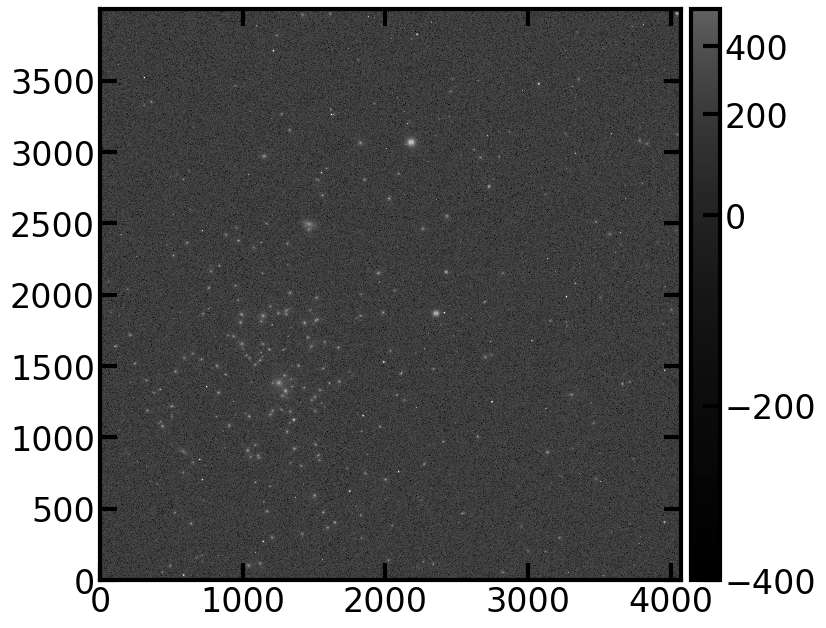

In [40]:

fits_data = ResourcePath(image_url).read()

#we don't have a way to read the ExposureF directly from a url right now, 
#so you have to do the extra step of allocating memory

mem = MemFileManager(len(fits_data))
mem.setData(fits_data, len(fits_data))
exposure = ExposureF(mem)

fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(exposure.image)
plt.show()


### 4.3 Optional: Creating cutouts of LSST images using the cutout tool

These pipelines are still under development, in the future its likely these will be packaged into more user-fiendly functions. We may develop new ways that would be recommended ways for users to do these operations.




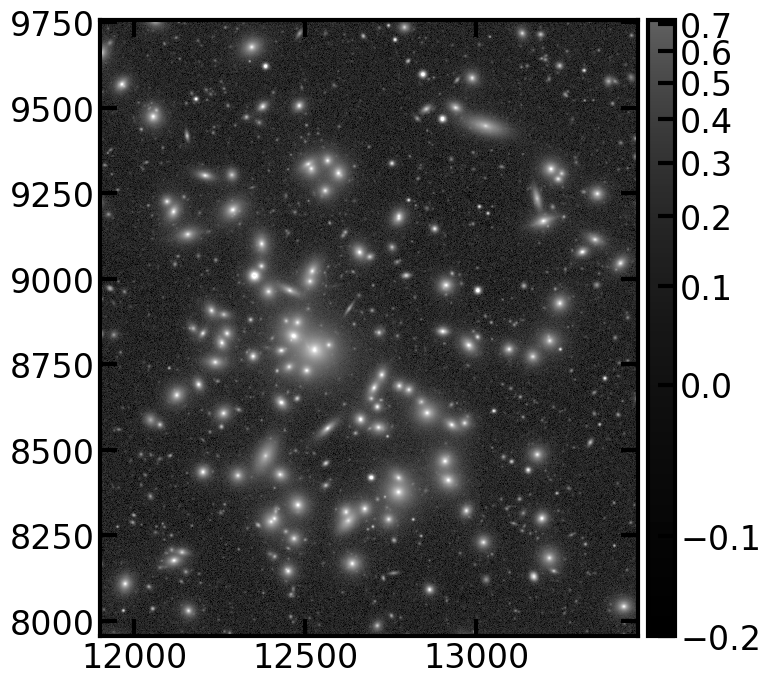

In [41]:

service = get_tap_service("tap")
spherePoint = geom.SpherePoint(my_ra*geom.degrees, my_dec*geom.degrees)

query = "SELECT access_format, access_url, dataproduct_subtype, " + \
    "lsst_patch, lsst_tract, lsst_band, s_ra, s_dec  " + \
    "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
    "AND obs_collection = 'LSST.DP02' " + \
    "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
    "AND lsst_tract = " + str(my_tract) + " " + \
    "AND lsst_patch = " + str(my_patch) + " " + \
    "AND lsst_band = 'i' "

results = service.search(query)
results.to_table().show_in_notebook()

dataLinkUrl = results[0].getdataurl()

auth_session = service._session
dl_results = DatalinkResults.from_result_url(dataLinkUrl,
                                             session=auth_session)

f"Datalink status: {dl_results.status}. Datalink service url: {dataLinkUrl}"

sq = SodaQuery.from_resource(dl_results,
                             dl_results.get_adhocservice_by_id("cutout-sync"),
                             session=auth_session)

sphereRadius = 0.05 * u.deg

sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
             spherePoint.getDec().asDegrees() * u.deg,
             sphereRadius)


cutout_bytes = sq.execute_stream().read()

mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure = ExposureF(mem)

#plotImage(ExposureF(mem))
#or:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(exposure.image)
plt.show()




## Additional Documentation

If you'd like some more information on `lsst.afw.display`, please have a look at the following websites:

* [Info on image indexing conventions.](https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html)  
* [afw.display Doxygen website](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/namespacelsst_1_1afw_1_1display.html)  
* [afw.display GitHub website](https://github.com/RobertLuptonTheGood/afw/tree/master/python/lsst/afw/display)  
* [Getting Started on Image Display (pipelines.lsst.io)](https://pipelines.lsst.io/getting-started/display.html)

In [42]:
#JUNK CODE:

In [43]:
#### OR WITH TAP ####
# deepcoadd:
query = "SELECT s_ra, s_dec, lsst_patch, lsst_tract, s_region " + \
        "FROM ivoa.ObsCore " + \
        "WHERE dataproduct_type = 'image' " + \
        "AND obs_collection = 'LSST.DP02' " + \
        "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
        "AND CONTAINS(POINT('ICRS', " + str(my_ra) + \
        ", " + str(my_dec) + "), " + \
        "s_region) = 1"

results = service.search(query)

tract = results['lsst_tract'][0]
patch = results['lsst_patch'][0]
############
# calexp:
center_coords = str(my_ra)+','+str(my_dec)
radius = "4.0"

# fix this. use ccdVisitId table instead because bounding box.
results = service.search("SELECT ra, decl, band, ccdVisitId "
                         "FROM dp02_dc2_catalogs.Source "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + center_coords + ", " + radius + ")) = 1 " + \
 
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
                         "CIRCLE('ICRS', " + str(my_ra) + ", " + str(my_dec) + ")) = 1 ")# + \
                         #+ " AND band = i ")

Src = results.to_table()
Src

DALQueryError: ADQL syntax error: Encountered " "WHERE" "WHERE "" at line 1, column 163.
Was expecting one of:
    <EOF> 
    "GROUP" ...
    "LIMIT" ...
    "ORDER" ...
    "OFFSET" ...
    "HAVING" ...
    ";" ...
    "GROUP" ...
    "HAVING" ...
    "ORDER" ...
    "LIMIT" ...
    "OFFSET" ...
    "LIMIT" ...